# Seperating stock to forcast for certain dates depending on the product

In [1]:
%pip install nbformat pandas numpy matplotlib seaborn scikit-learn xgboost

     ------------------------------------ 124.9/124.9 MB 435.6 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
# # import datasets and transformations (reusability purposes)
# from IPython import get_ipython

# get_ipython().run_line_magic('run', 'datasets.ipynb')

In [4]:
import sys
sys.path.append('../src')

In [5]:
from data_config import ProductHandler as ph

d:\SCM---ML-Visualisation\notebooks\../src\datasets.py:7: DtypeWarning: Columns (4,6,20,50,52) have mixed types. Specify dtype option on import or set low_memory=False.
  products_s = pd.read_csv(
d:\SCM---ML-Visualisation\notebooks\../src\datasets.py:9: DtypeWarning: Columns (5,29,42,48) have mixed types. Specify dtype option on import or set low_memory=False.
  tickets_c_i = pd.read_csv(
d:\SCM---ML-Visualisation\notebooks\../src\datasets.py:12: DtypeWarning: Columns (43,57,106,141,146,211,212,247,255,294,298,316,327,332,350,354) have mixed types. Specify dtype option on import or set low_memory=False.
  tickets_c_m = pd.read_csv(
d:\SCM---ML-Visualisation\notebooks\../src\datasets.py:15: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  sp_inv_adds = pd.read_csv(


----- DROP BOOLEAN AND NULL COLUMNS (NOT NEEDED) -----

Merged Data - Columns to be dropped (Missing Vals): ['BackStage_DefaultReportForm', 'BackStage_SmartMarkSet', 'BillCounty', 'CoreType', 'EndUserNum', 'EndUserPO', 'Equip3_ID', 'Equip3_Status', 'Est_v_Act_Notes', 'Ink_Status', 'JDF_Note_to_DFE', 'JDF_Send_Msg', 'MiscChargeDesc1', 'MiscChargeDesc2', 'MiscChargeDesc3', 'MiscChargeDesc4', 'PlateStat', 'ProofStat', 'Roto_CEL_Product_ID', 'Roto_Quote_Line_ID', 'Roto_Quote_Number', 'Schedule_Status', 'ShipAttn_EmailAddress', 'ShipCounty', 'ShipStat', 'Tag_x', 'Tool3Descr', 'Tool4Descr', 'Tool5Descr', 'ToolNo3', 'ToolNo4', 'ToolNo5', 'ToolStat', 'UserDef_MR_1_Lb', 'UserDef_MR_2_Lb', 'Assigned', 'Desc2_x', 'ediLineNumber', 'eTraxx_Customer_Notes', 'Location_x', 'PO_Number', 'Adhesive', 'Alternate', 'eTraxx_Forecast_Range', 'Material', 'Tag_y', 'UPC']

Merged Data - Columns to be dropped (All cols with rows same vals): ['Act_OTHER_Hours', 'ActArtwork', 'ActFinMaterial', 'ActPostPressHours',

d:\SCM---ML-Visualisation\notebooks\../src\datasets.py:102: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  merged_data['OrderDate'] = pd.to_datetime(
d:\SCM---ML-Visualisation\notebooks\../src\datasets.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data['OrderDate'] = pd.to_datetime(
d:\SCM---ML-Visualisation\notebooks\../src\datasets.py:104: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  merged_data['Ship_by_Date'] = pd.to_datetime(
d:\SCM---ML-Visualisation\

In [6]:
ph.custom_prod_set()

All custom codes for existing products: 
{'568', '808', 'BLU', '445', '175', '464', '55Y', '10W', 'PFG', 'SQU', '36U', '94Z', '98W', 'VO-', '292', '196', 'CMI', '255', '764', '46U', '888', '213', '041', 'JP-', '31Z', '51X', '73X', '773', '705', '976', '67X', 'TNS', '36-', 'Y-3', 'PAN', '115', 'MSP', '36X', 'US-', '34S', '23V', '471', 'BBJ', '245', '762', '25V', '073', '622', '96S', '06T', '235', '508', '266', 'TFO', '00Z', 'ED-', '57X', 'MX-', '709', '252', 'FLB', 'SBR', '256', '15S', '594', 'PER', 'OL-', '95Z', '24W', '81Y', '849', '-TR', '-08', 'WAN', '24V', '45T', 'POS', 'MJ-', '27S', '284', '3-1', 'PB-', 'TI-', '68T', '001', '19X', 'OV-', '147', '65Y', '593', 'GOR', '426', 'IMP', 'DEV', 'TOG', '924', '307', '36Z', '02U', '743', '531', 'S-J', '82Y', '99Y', '198', '006', '119', 'QUI', '673', '831', '898', '181', '19T', '363', 'WF-', 'CPK', '722', '86Y', 'CMX', '953', '13V', '459', 'EB-', 'CHB', '96W', '22Z', '457', '69Y', '336', '-SO', '511', '443', '052', 'SK-', '71Z', '05R', 'LBL',

In [7]:
# # display the highest order quantity customers 
# ph.highest_customs()

In [8]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# define the features and target variable from 'product_sales'
# CHANGE THE CUSTOMER CODE HERE >>>>>>>>>>
custom_code_df = pd.DataFrame(ph.get_custom_code_data('UND'))

# customer code for later referencing
custom_ref = custom_code_df.loc[0, 'ProductNumber'][:3].lower().upper()
print(custom_ref)

custom_code_df.head()

UND


,ProductNumber,order_year,order_month,order_week,order_weekday,is_weekend,Customer_Num,OrderQuantity,prev_month_sales,prev_week_sales,...,moving_avg_3m,moving_avg_6m,moving_avg_12m,moving_avg_18m,sales_2022,sales_2023,sales_2024,growth_2023,growth_2024,PhysicalInv
0,UND-026-0002Y,2022,1,4,2,0,194.0,30000,40000.00000,40000.00000,...,37333.333333,37000.000000,37000.000000,37000.000000,30000,0,0,-100.0,NaN,0
1,UND-026-0002Y,2022,3,12,1,0,194.0,40000,42000.00000,42000.00000,...,39333.333333,39333.333333,39333.333333,39333.333333,40000,0,0,-100.0,NaN,0
2,UND-026-0002Y,2022,6,23,4,0,194.0,42000,36000.00000,36000.00000,...,39000.000000,39000.000000,39000.000000,39000.000000,42000,0,0,-100.0,NaN,0
3,UND-026-0002Y,2024,7,28,2,0,194.0,36000,110031.53337,110031.53337,...,36000.000000,36000.000000,36000.000000,36000.000000,0,0,36000,NaN,inf,0
4,UND-026-0003Y,2022,3,12,1,0,194.0,10000,10000.00000,10000.00000,...,11333.333333,12666.666667,12666.666667,12666.666667,10000,0,0,-100.0,NaN,0


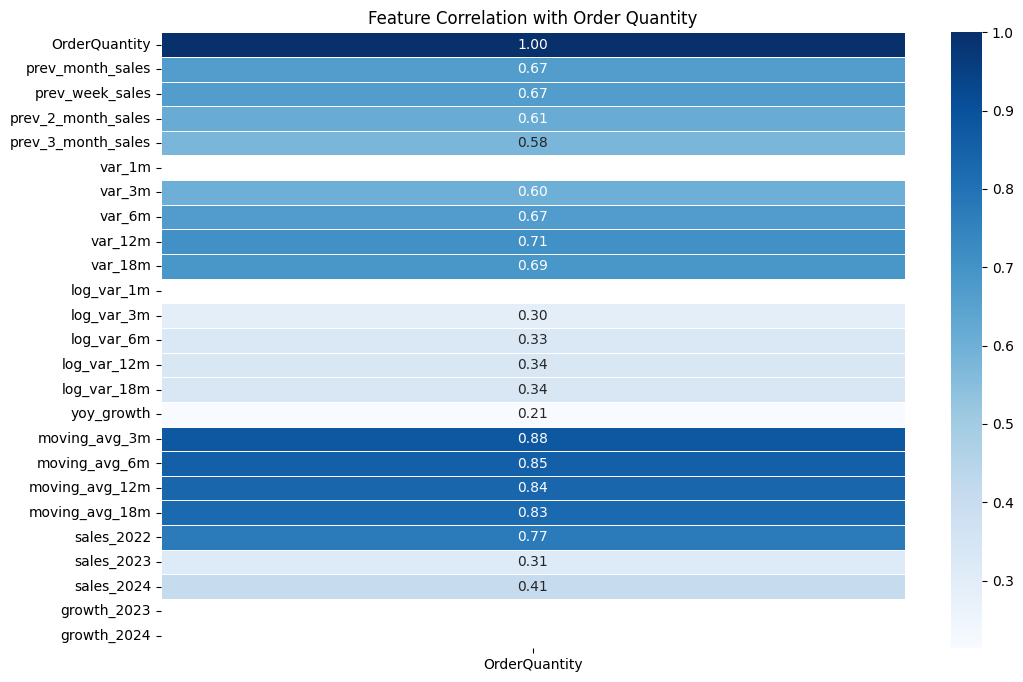

In [9]:
ph.feature_importance(custom_code_df)

In [10]:
from scipy import stats

# Define a function to compute z-scores within each product group
def compute_zscore(group, threshold=3):
    # Only compute z-score if there are at least 2 data points in the group
    if len(group) >= 2:
        group['z_score'] = np.abs(stats.zscore(group['OrderQuantity']))
    else:
        group['z_score'] = 0  # or np.nan if preferred
    return group

# Group by "ProductNumber" and compute z-scores for "OrderQuantity" within each group
df_grouped = custom_code_df.groupby('ProductNumber').apply(compute_zscore)

# Define your threshold for what constitutes an "unusually high" order
z_threshold = 3

# Filter for outliers (orders with a z_score greater than the threshold)
df_outliers = df_grouped[df_grouped['z_score'] > z_threshold]

# Display the results
print("Unusually high order quantities (per ProductNumber):")
print(df_outliers[['ProductNumber', 'OrderQuantity', 'z_score']])

print(f'Dropping: \n{df_outliers.count()}')
# Keep only rows where the z-score is within the acceptable range
df_cleaned = df_grouped[df_grouped['z_score'] <= z_threshold].drop(columns=['z_score'])

# Reset index for clarity
df_cleaned.reset_index(drop=True, inplace=True)

custom_code_df = df_cleaned


Unusually high order quantities (per ProductNumber):
                    ProductNumber  OrderQuantity   z_score
ProductNumber                                             
UND-026-0008Z 49    UND-026-0008Z         320000  3.890424
UND-026-0012Z 191   UND-026-0012Z        2224000  3.164748
UND-026-0015Z 324   UND-026-0015Z         380000  3.186842
              362   UND-026-0015Z         408000  3.561399
UND-026-0016Y 381   UND-026-0016Y         320000  4.035946
UND-026-0020Z 514   UND-026-0020Z         360000  4.646387
UND-026-0022Z 558   UND-026-0022Z        1344000  3.518711
UND-026-0024Z 615   UND-026-0024Z         180000  3.049619
UND-026-0031Y 748   UND-026-0031Y        1080000  3.225644
              749   UND-026-0031Y        1040000  3.048499
UND-026-0036Z 942   UND-026-0036Z         180000  3.483565
UND-026-0037Z 983   UND-026-0037Z         296000  5.443305
UND-026-0049Y 1223  UND-026-0049Y         140000  3.952076
UND-026-0055Y 1302  UND-026-0055Y         234000  3.166945
UND

C:\Users\44777\AppData\Local\Temp\ipykernel_2180\1363007664.py:7: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  group['z_score'] = np.abs(stats.zscore(group['OrderQuantity']))
C:\Users\44777\AppData\Local\Temp\ipykernel_2180\1363007664.py:7: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  group['z_score'] = np.abs(stats.zscore(group['OrderQuantity']))
C:\Users\44777\AppData\Local\Temp\ipykernel_2180\1363007664.py:7: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  group['z_score'] = np.abs(stats.zscore(group['OrderQuantity']))
C:\Users\44777\AppData\Local\Temp\ipykernel_2180\1363007664.py:7: RuntimeWarning: Precision

In [11]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
df = custom_code_df

features = ['ProductNumber', 'order_month',
            'prev_month_sales', 'prev_week_sales', 'prev_2_month_sales', 'prev_3_month_sales',
            'moving_avg_3m', 'moving_avg_6m', 'moving_avg_12m', 'moving_avg_18m',
            'var_3m', 'var_6m', 'var_12m', 'var_18m',
            'log_var_3m', 'log_var_6m', 'log_var_12m', 'log_var_18m',
            'yoy_growth', 'sales_2023', 'sales_2024'
            ]
target = 'OrderQuantity'

X = df[features]
y = df[target]

# one-hot encoding for categorical features
categorical_features = ['ProductNumber']
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# preprocessor (keeps numerical features as is)
preprocessor = ColumnTransformer(
    transformers=[
        # one-hot encode categorical features
        ('cat', encoder, categorical_features)
    ], remainder='passthrough'
)

# transform the features
X_transformed = preprocessor.fit_transform(X)


In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

# normalize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [13]:
customer_total = df.copy()

# define features and target
features = ['ProductNumber', 'order_month', 'order_week', 'order_weekday',
            'prev_month_sales', 'prev_week_sales', 'prev_2_month_sales', 'prev_3_month_sales',
            'moving_avg_3m', 'moving_avg_6m', 'moving_avg_12m', 'moving_avg_18m',
            'var_3m', 'var_6m', 'var_12m', 'var_18m',
            'log_var_3m', 'log_var_6m', 'log_var_12m', 'log_var_18m',
            'yoy_growth', 'sales_2023', 'sales_2024'
           ]
target = 'OrderQuantity'

# filter the top products
total_X = customer_total[features]  # Features from top products
total_y = customer_total[target]    # Target variable

# define categorical and numeric features
categorical_features = ['ProductNumber']
numeric_features = list(set(features) - set(categorical_features))  # All other features are numeric

# Define transformations
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
scaler = StandardScaler()

# ColumnTransformer to apply transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', encoder, categorical_features),   # One-hot encode categorical features
        ('num', scaler, numeric_features)        # Standardize numeric features
    ]
)

# Train-test split
total_X_train, total_X_val, total_y_train, total_y_val = train_test_split(total_X, total_y, test_size=0.2, random_state=42)

# Transform the features
total_X_train_transformed = preprocessor.fit_transform(total_X_train)
total_X_val_transformed = preprocessor.transform(total_X_val)

# Output the shape
print(f"Train Shape: {total_X_train_transformed.shape}, Validation Shape: {total_X_val_transformed.shape}")
print("Feature processing for top products completed successfully!")

customer_total.head()


Train Shape: (2812, 260), Validation Shape: (704, 260)
Feature processing for top products completed successfully!


,ProductNumber,order_year,order_month,order_week,order_weekday,is_weekend,Customer_Num,OrderQuantity,prev_month_sales,prev_week_sales,...,moving_avg_3m,moving_avg_6m,moving_avg_12m,moving_avg_18m,sales_2022,sales_2023,sales_2024,growth_2023,growth_2024,PhysicalInv
0,UND-026-0002Y,2022,1,4,2,0,194.0,30000,40000.00000,40000.00000,...,37333.333333,37000.000000,37000.000000,37000.000000,30000,0,0,-100.0,NaN,0
1,UND-026-0002Y,2022,3,12,1,0,194.0,40000,42000.00000,42000.00000,...,39333.333333,39333.333333,39333.333333,39333.333333,40000,0,0,-100.0,NaN,0
2,UND-026-0002Y,2022,6,23,4,0,194.0,42000,36000.00000,36000.00000,...,39000.000000,39000.000000,39000.000000,39000.000000,42000,0,0,-100.0,NaN,0
3,UND-026-0002Y,2024,7,28,2,0,194.0,36000,110031.53337,110031.53337,...,36000.000000,36000.000000,36000.000000,36000.000000,0,0,36000,NaN,inf,0
4,UND-026-0003Y,2022,3,12,1,0,194.0,10000,10000.00000,10000.00000,...,11333.333333,12666.666667,12666.666667,12666.666667,10000,0,0,-100.0,NaN,0


In [14]:
# the top 10 (or change) products by total actual order quantity
top_products = df.groupby('ProductNumber')['OrderQuantity'].sum().nlargest(1)

# extract top product code rows from the original df
top_prods_df = df[df['ProductNumber'].isin(top_products.index)]

# Extract top product numbers
top_product_numbers = top_products.index.tolist()  # List of top product numbers

top_prods_df.head()

unique_order_years = custom_code_df['order_year'].unique()
print(unique_order_years)

[2022 2024 2023 2021 2025]


In [15]:
# define features and target
features = ['ProductNumber', 'order_month', 
            'prev_month_sales', 'prev_week_sales', 'prev_2_month_sales', 'prev_3_month_sales',
            'moving_avg_3m', 'moving_avg_6m', 'moving_avg_12m', 'moving_avg_18m',
            'var_3m', 'var_6m', 'var_12m', 'var_18m',
            'log_var_3m', 'log_var_6m', 'log_var_12m', 'log_var_18m',
            'yoy_growth', 'sales_2023', 'sales_2024'
           ]
target = 'OrderQuantity'

# filter the top products
tp_X = top_prods_df[features]  # Features from top products
tp_y = top_prods_df[target]    # Target variable

# define categorical and numeric features
categorical_features = ['ProductNumber']
numeric_features = list(set(features) - set(categorical_features))  # All other features are numeric

# Define transformations
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
scaler = StandardScaler()

# ColumnTransformer to apply transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', encoder, categorical_features),   # One-hot encode categorical features
        ('num', scaler, numeric_features)        # Standardize numeric features
    ]
)

# Train-test split
tp_X_train, tp_X_val, tp_y_train, tp_y_val = train_test_split(tp_X, tp_y, test_size=0.2, random_state=42)

# Transform the features
tp_X_train_transformed = preprocessor.fit_transform(tp_X_train)
tp_X_val_transformed = preprocessor.transform(tp_X_val)

# Output the shape
print(f"Train Shape: {tp_X_train_transformed.shape}, Validation Shape: {tp_X_val_transformed.shape}")
print("Feature processing for top products completed successfully!")


Train Shape: (24, 21), Validation Shape: (7, 21)
Feature processing for top products completed successfully!


In [16]:
from sklearn.ensemble import RandomForestRegressor
from model_utils import *

In [17]:
# train the model with scaled features (Random Forest Regressor)
rf = RandomForestRegressor()
rf_params = find_best_hyperparameters(rf, param_grids(rf.__class__.__name__), X_train_scaled, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
RandomForestRegressor Best Parameters: {'criterion': 'squared_error', 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}


In [18]:
rf = RandomForestRegressor(**rf_params)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_val_scaled)

In [19]:
print('---------------------- TRAINING PERFORMANCE ----------------------')
evaluate_model(rf, X_train_scaled, y_train)
print('--------------------------------------------')

print('---------------------- TEST PERFORMANCE ----------------------')
evaluate_model(rf, X_val_scaled, y_val)
print('--------------------------------------------')

---------------------- TRAINING PERFORMANCE ----------------------
Evaluating model...
Model: RandomForestRegressor
Mean Absolute Error (MAE): 39289.1815
Mean Squared Error (MSE): 30874830494.5965
Root Mean Squared Error (RMSE): 175712.3516
R-squared (R²): 0.7410
--------------------------------------------
---------------------- TEST PERFORMANCE ----------------------
Evaluating model...
Model: RandomForestRegressor
Mean Absolute Error (MAE): 44671.4216
Mean Squared Error (MSE): 22659267596.5611
Root Mean Squared Error (RMSE): 150529.9558
R-squared (R²): 0.7331
--------------------------------------------


In [20]:
# train the model with scaled features (Random Forest Regressor) - TOTAL CUSTOM PRODUCTS IMPLEMENTATION
total_rf = RandomForestRegressor()
total_rf_params = find_best_hyperparameters(total_rf, param_grids(total_rf.__class__.__name__), total_X_train_transformed, total_y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
RandomForestRegressor Best Parameters: {'criterion': 'squared_error', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}


In [21]:
total_rf = RandomForestRegressor(**total_rf_params)
total_rf.fit(total_X_train_transformed, total_y_train)
total_y_pred_rf = total_rf.predict(total_X_val_transformed)

In [22]:
print('---------------------- TRAINING PERFORMANCE ----------------------')
evaluate_model(total_rf, total_X_train_transformed, total_y_train)
print('--------------------------------------------')

print('---------------------- TEST PERFORMANCE ----------------------')
evaluate_model(total_rf, total_X_val_transformed, total_y_val)
print('--------------------------------------------')

---------------------- TRAINING PERFORMANCE ----------------------
Evaluating model...
Model: RandomForestRegressor
Mean Absolute Error (MAE): 39617.6936
Mean Squared Error (MSE): 31684692979.5500
Root Mean Squared Error (RMSE): 178001.9466
R-squared (R²): 0.7342
--------------------------------------------
---------------------- TEST PERFORMANCE ----------------------
Evaluating model...
Model: RandomForestRegressor
Mean Absolute Error (MAE): 45345.5952
Mean Squared Error (MSE): 23553532343.7684
Root Mean Squared Error (RMSE): 153471.6011
R-squared (R²): 0.7226
--------------------------------------------


[52289.46970590469, 91272.75120798533, 138928.57938303528, 155672.37326072616, 117807.41111176409, 98749.6520163703, 48120.49160806515, 139591.48683261184, 65027.88385307505, 148221.17145376123, 877053.9432609874, 68285.3335492337, 22568.393401916506, 190767.4248896529, 20039.796057844866, 78869.39435366831, 15217.825800016977, 21861.042911337037, 19554.83109129433, 1327217.5102773039, 74502.56683839037, 361274.76460794103, 76356.44160741221, 33169.361071934596, 279241.5295158058, 20323.292808174592, 23999.41859327463, 30698.93383236541, 54883.49642024645, 1042473.3635808638, 35554.67969723775, 71648.11854064408, 33849.01498583115, 28109.066138926424, 71407.38123298531, 20014.111069774255, 65784.59551069845, 626392.5256154666, 32674.508419770802, 34437.88708676944, 670418.8255238915, 94873.77049631659, 45494.46036316625, 52505.09816353236, 69899.81080031079, 87613.05276337008, 64137.225116644615, 56738.18182389507, 73292.33053496212, 36184.883984651395, 387938.3814551463, 813231.756108

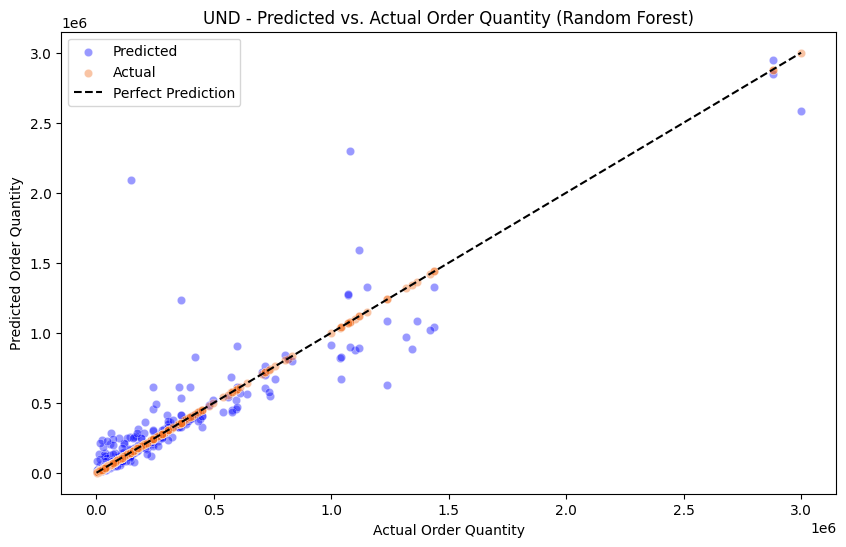

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

print(y_pred_rf.tolist())

plt.figure(figsize=(10, 6))

# scatter plot, actual vs predicted values
sns.scatterplot(x=y_val, y=y_pred_rf, alpha=0.4, color='blue', label='Predicted')  # Predicted values in blue

# actual values in red
sns.scatterplot(x=y_val, y=y_val, alpha=0.4, color='#f26d1d', label='Actual')

# reference line for perfect prediction
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], '--', color='black', label="Perfect Prediction")

plt.xlabel("Actual Order Quantity")
plt.ylabel("Predicted Order Quantity")
plt.title(f"{custom_ref} - Predicted vs. Actual Order Quantity (Random Forest)")
plt.legend()

plt.show()

C:\Users\44777\AppData\Local\Temp\ipykernel_2180\1606837329.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_prods_df['OrderDate'] = pd.to_datetime(top_prods_df[['order_year', 'order_month']].astype(str).agg('-'.join, axis=1))


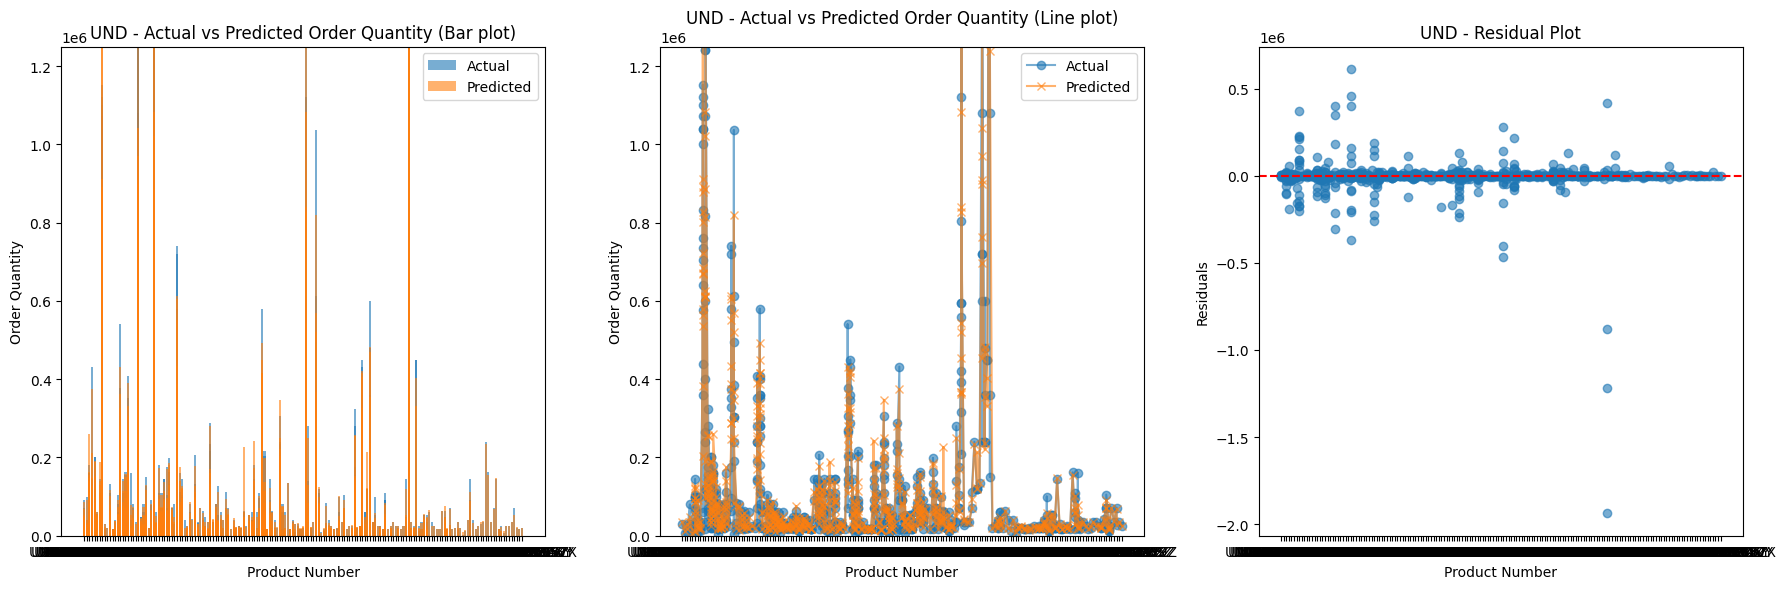

In [24]:
# Convert order year and month to datetime format
top_prods_df['OrderDate'] = pd.to_datetime(top_prods_df[['order_year', 'order_month']].astype(str).agg('-'.join, axis=1))

# Sort by OrderDate to maintain time order
top_prods_df = top_prods_df.sort_values(by='OrderDate')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Bar plot, actual and predicted values over time
axes[0].bar(df.loc[y_val.index, 'ProductNumber'], y_val, label='Actual', alpha=0.6)
axes[0].bar(df.loc[y_val.index, 'ProductNumber'], y_pred_rf, label='Predicted', alpha=0.6)
axes[0].set_xlabel('Product Number')
axes[0].set_ylabel('Order Quantity')
axes[0].set_title(f'{custom_ref} - Actual vs Predicted Order Quantity (Bar plot)')
axes[0].set_ylim(0, 1250000)
axes[0].legend()

# Line plot, actual and predicted values
sorted_indices = df.loc[y_val.index, 'ProductNumber'].argsort()
sorted_products = df.loc[y_val.index, 'ProductNumber'].iloc[sorted_indices]
sorted_actual = y_val.iloc[sorted_indices]
sorted_predicted = y_pred_rf[sorted_indices]

axes[1].plot(sorted_products, sorted_actual, label='Actual', alpha=0.6, marker='o')
axes[1].plot(sorted_products, sorted_predicted, label='Predicted', alpha=0.6, marker='x')
axes[1].set_xlabel('Product Number')
axes[1].set_ylabel('Order Quantity')
axes[1].set_title(f'{custom_ref} - Actual vs Predicted Order Quantity (Line plot)')
axes[1].set_ylim(0, 1250000)
axes[1].legend()

# Residual plot
residuals = y_val - y_pred_rf
axes[2].scatter(df.loc[y_val.index, 'ProductNumber'], residuals, alpha=0.6)
axes[2].axhline(y=0, color='r', linestyle='--')
axes[2].set_xlabel('Product Number')
axes[2].set_ylabel('Residuals')
axes[2].set_title(f'{custom_ref} - Residual Plot')

plt.tight_layout()
plt.show()


In [25]:
# Convert order year and month to datetime format
customer_total['OrderDate'] = pd.to_datetime(customer_total[['order_year', 'order_month']].astype(str).agg('-'.join, axis=1))

# Sort by OrderDate to maintain time order
customer_total = customer_total.sort_values(by='OrderDate')

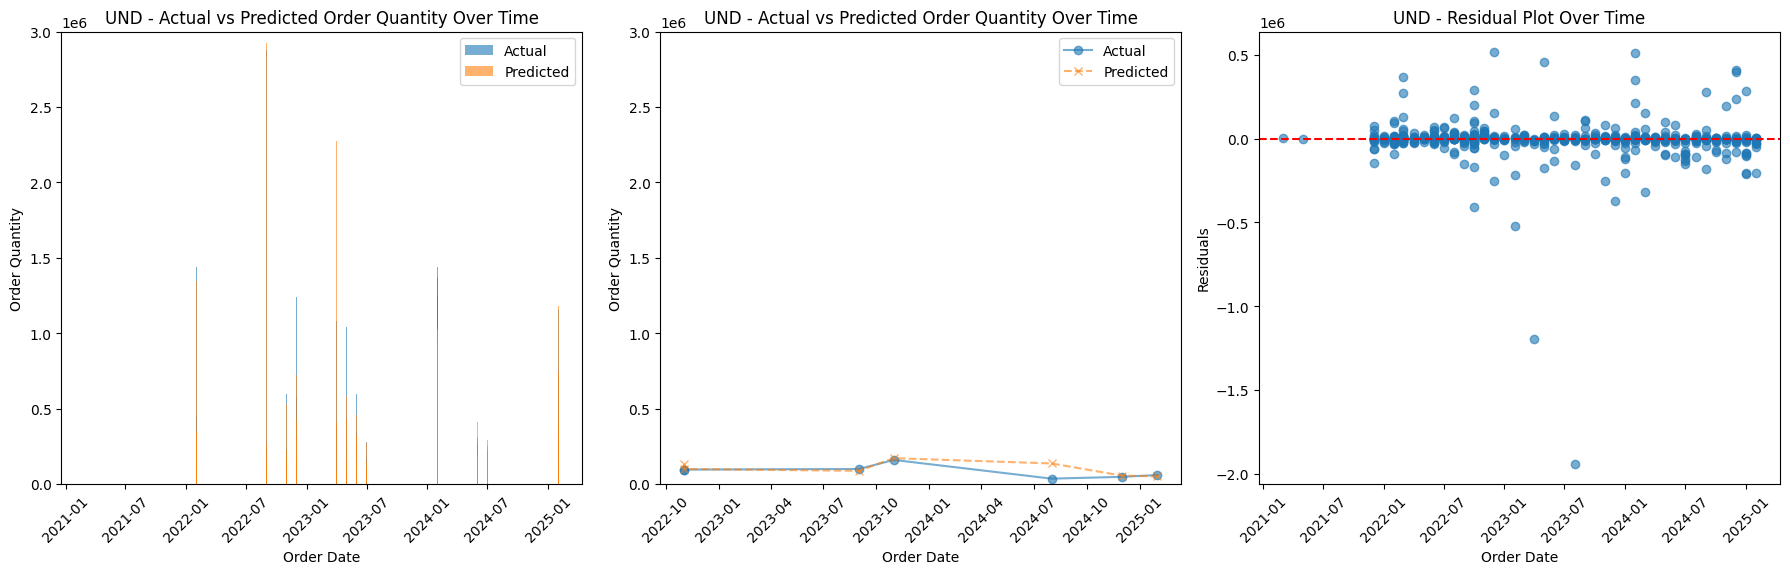

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Bar plot, actual and predicted values over time
axes[0].bar(customer_total.loc[total_y_val.index, 'OrderDate'], total_y_val, label='Actual', alpha=0.6)
axes[0].bar(customer_total.loc[total_y_val.index, 'OrderDate'], total_y_pred_rf, label='Predicted', alpha=0.6)
axes[0].set_xlabel('Order Date')
axes[0].set_ylabel('Order Quantity')
axes[0].set_title(f'{custom_ref} - Actual vs Predicted Order Quantity Over Time')
axes[0].set_ylim(0, 3000000)
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for readability

# Line plot, actual and predicted values over time
sorted_indices = top_prods_df.loc[tp_y_val.index, 'OrderDate'].argsort()
sorted_dates = top_prods_df.loc[tp_y_val.index, 'OrderDate'].iloc[sorted_indices]
sorted_actual = total_y_val.iloc[sorted_indices]
sorted_predicted = total_y_pred_rf[sorted_indices]

axes[1].plot(sorted_dates, sorted_actual, label='Actual', alpha=0.6, marker='o', linestyle='-')
axes[1].plot(sorted_dates, sorted_predicted, label='Predicted', alpha=0.6, marker='x', linestyle='--')
axes[1].set_xlabel('Order Date')
axes[1].set_ylabel('Order Quantity')
axes[1].set_title(f'{custom_ref} - Actual vs Predicted Order Quantity Over Time')
axes[1].set_ylim(0, 3000000)
axes[1].legend()
axes[1].tick_params(axis='x', rotation=45)

# Residual plot over time
residuals = total_y_val - total_y_pred_rf
axes[2].scatter(customer_total.loc[total_y_val.index, 'OrderDate'], residuals, alpha=0.6)
axes[2].axhline(y=0, color='r', linestyle='--')
axes[2].set_xlabel('Order Date')
axes[2].set_ylabel('Residuals')
axes[2].set_title(f'{custom_ref} - Residual Plot Over Time')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [27]:
# # to see dataframe structure
# customer_total.head()


In [28]:
# # to see prediction nparray structure
# total_y_pred_rf

In [29]:
# # Group data by OrderDate and sum the relevant numerical columns
# customer_total = top_prods_df.groupby('OrderDate').sum(numeric_only=True).reset_index()

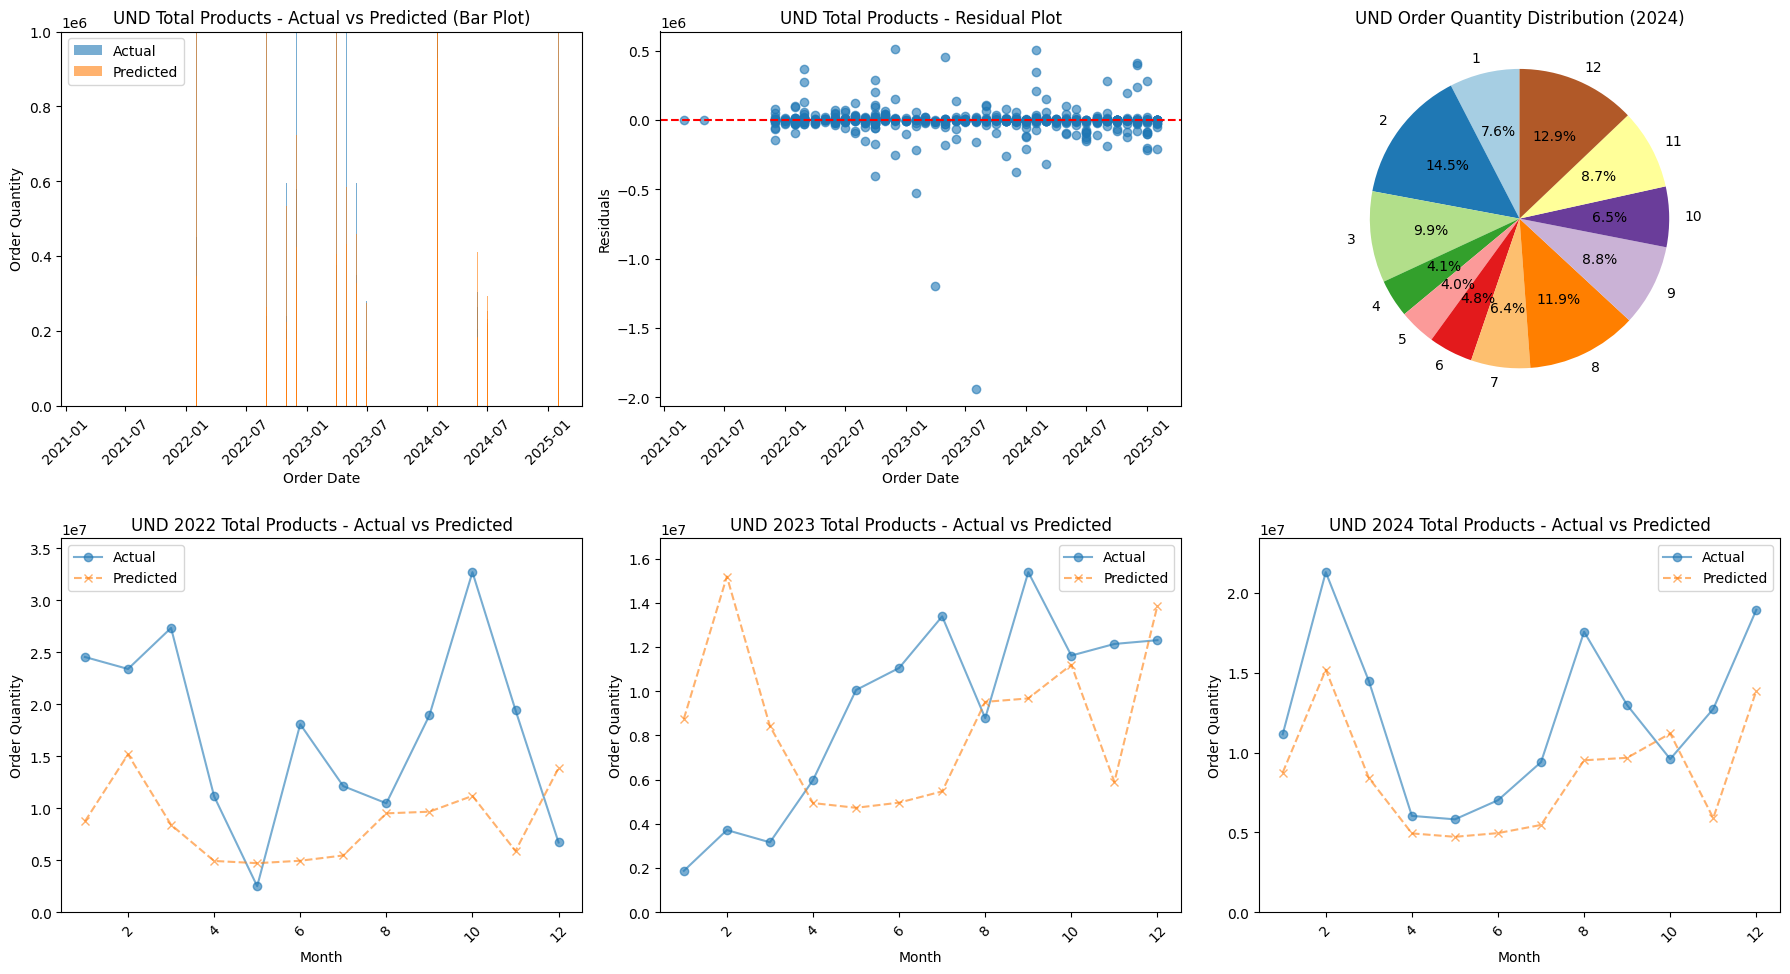

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.3)  # Adjust layout for better spacing

# Bar plot: Actual vs. Predicted Order Quantity
axes[0, 0].bar(customer_total.loc[total_y_val.index, 'OrderDate'], total_y_val, label='Actual', alpha=0.6)
axes[0, 0].bar(customer_total.loc[total_y_val.index, 'OrderDate'], total_y_pred_rf, label='Predicted', alpha=0.6)
axes[0, 0].set_xlabel('Order Date')
axes[0, 0].set_ylabel('Order Quantity')
axes[0, 0].set_title(f'{custom_ref} Total Products - Actual vs Predicted (Bar Plot)')
axes[0, 0].set_ylim(0, 1_000_000)
axes[0, 0].legend()
axes[0, 0].tick_params(axis='x', rotation=45)

# Residual Plot
residuals = total_y_val - total_y_pred_rf
axes[0, 1].scatter(customer_total.loc[total_y_val.index, 'OrderDate'], residuals, alpha=0.6)
axes[0, 1].axhline(y=0, color='r', linestyle='--')
axes[0, 1].set_xlabel('Order Date')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title(f'{custom_ref} Total Products - Residual Plot')
axes[0, 1].tick_params(axis='x', rotation=45)

# Pie Chart: Order Quantity per Month (2024)
order_2024 = customer_total[customer_total['order_year'] == 2024].groupby('order_month')['OrderQuantity'].sum()
axes[0, 2].pie(order_2024, labels=order_2024.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
axes[0, 2].set_title(f'{custom_ref} Order Quantity Distribution (2024)')

# Line Plots: Yearly Trends
for i, year in enumerate([2022, 2023, 2024]):  
    yearly_df = customer_total[customer_total['order_year'] == year]

    if yearly_df.empty:
        continue  # skip if no data for that year

    # Aggregate OrderQuantity per month
    monthly_actual = yearly_df.groupby('order_month')['OrderQuantity'].sum()

    # Convert total_y_pred_rf to Pandas Series with index from customer_total
    pred_series = pd.Series(total_y_pred_rf, index=total_y_val.index)

    # Group predictions by month
    monthly_predicted = pred_series.groupby(customer_total.loc[total_y_val.index, 'order_month']).sum()

    # Sort for proper plotting
    monthly_actual = monthly_actual.sort_index()
    monthly_predicted = monthly_predicted.reindex(monthly_actual.index)  # Ensure same months

    # Plot actual and predicted values for the year
    axes[1, i].plot(monthly_actual.index, monthly_actual, label='Actual', alpha=0.6, marker='o', linestyle='-')
    axes[1, i].plot(monthly_predicted.index, monthly_predicted, label='Predicted', alpha=0.6, marker='x', linestyle='--')

    axes[1, i].set_xlabel('Month')
    axes[1, i].set_ylabel('Order Quantity')
    axes[1, i].set_title(f'{custom_ref} {year} Total Products - Actual vs Predicted')
    axes[1, i].set_ylim(0, max(monthly_actual.max(), monthly_predicted.max()) * 1.1)  # Scale Y axis
    axes[1, i].legend()
    axes[1, i].tick_params(axis='x', rotation=45)

# Adjust layout for better spacing between subplots
plt.tight_layout()
plt.show()


In [31]:
has_orders_2022 = not customer_total[customer_total['order_year'] == 2022].empty
print(f"Orders in 2022 exist: {has_orders_2022}")


Orders in 2022 exist: True


In [32]:
customer_total.head(10)

,ProductNumber,order_year,order_month,order_week,order_weekday,is_weekend,Customer_Num,OrderQuantity,prev_month_sales,prev_week_sales,...,moving_avg_6m,moving_avg_12m,moving_avg_18m,sales_2022,sales_2023,sales_2024,growth_2023,growth_2024,PhysicalInv,OrderDate
2494,UND-026-0107Z,2021,3,9,0,0,194.0,36000,168000.0,168000.0,...,193000.000000,159000.000000,138000.000000,0,0,0,NaN,NaN,18000,2021-03-01
2644,UND-026-0114Z,2021,3,9,2,0,194.0,36000,40000.0,40000.0,...,35333.333333,26000.000000,24470.588235,0,0,0,NaN,NaN,0,2021-03-01
1849,UND-026-0086Z,2021,3,9,0,0,194.0,144000,72000.0,72000.0,...,132000.000000,99000.000000,132666.666667,0,0,0,NaN,NaN,144000,2021-03-01
3070,UND-026-0151Z,2021,5,20,2,0,194.0,180000,18000.0,18000.0,...,72000.000000,45818.181818,45818.181818,0,0,0,NaN,NaN,0,2021-05-01
2789,UND-026-0124Z,2021,5,20,4,0,194.0,28000,28000.0,28000.0,...,29750.000000,29750.000000,29750.000000,0,0,0,NaN,NaN,0,2021-05-01
3032,UND-026-0147Z,2021,5,20,2,0,194.0,20000,20000.0,20000.0,...,20000.000000,33000.000000,32000.000000,0,0,0,NaN,NaN,0,2021-05-01
2793,UND-026-0125Z,2021,5,20,4,0,194.0,28000,35000.0,35000.0,...,33250.000000,33250.000000,33250.000000,0,0,0,NaN,NaN,0,2021-05-01
2587,UND-026-0110Y,2021,7,27,1,0,194.0,24000,20000.0,20000.0,...,30666.666667,26400.000000,26400.000000,0,0,0,NaN,NaN,0,2021-07-01
3095,UND-026-0155X,2021,9,36,4,0,194.0,20000,20000.0,20000.0,...,23200.000000,23200.000000,23200.000000,0,0,0,NaN,NaN,0,2021-09-01
360,UND-026-0016Y,2021,11,45,1,0,194.0,120000,140000.0,140000.0,...,120000.000000,105666.666667,101333.333333,0,0,0,NaN,NaN,4000,2021-11-01


In [33]:
# from powerbiclient import QuickVisualize, get_dataset_config, Report
# from powerbiclient.authentication import InteractiveLoginAuthentication, DeviceCodeLoginAuthentication
# import pandas as pd

# prod_sales = pd.read_csv(
#     '/Users/mwilko777/Desktop/Project/Software Artifact/datasets/stock_forecasting/final/product_sales.csv')

# # use DeviceCodeLoginAuthentication if want to sign in each time, else InteractiveLoginAuthentication
# auth = InteractiveLoginAuthentication()
# print("Authentication successful.")


# def visual():
#     dataset_config = get_dataset_config(prod_sales)
#     return QuickVisualize(dataset_config, auth)

# visual()

In [34]:
customer_total.head()

,ProductNumber,order_year,order_month,order_week,order_weekday,is_weekend,Customer_Num,OrderQuantity,prev_month_sales,prev_week_sales,...,moving_avg_6m,moving_avg_12m,moving_avg_18m,sales_2022,sales_2023,sales_2024,growth_2023,growth_2024,PhysicalInv,OrderDate
2494,UND-026-0107Z,2021,3,9,0,0,194.0,36000,168000.0,168000.0,...,193000.000000,159000.000000,138000.000000,0,0,0,NaN,NaN,18000,2021-03-01
2644,UND-026-0114Z,2021,3,9,2,0,194.0,36000,40000.0,40000.0,...,35333.333333,26000.000000,24470.588235,0,0,0,NaN,NaN,0,2021-03-01
1849,UND-026-0086Z,2021,3,9,0,0,194.0,144000,72000.0,72000.0,...,132000.000000,99000.000000,132666.666667,0,0,0,NaN,NaN,144000,2021-03-01
3070,UND-026-0151Z,2021,5,20,2,0,194.0,180000,18000.0,18000.0,...,72000.000000,45818.181818,45818.181818,0,0,0,NaN,NaN,0,2021-05-01
2789,UND-026-0124Z,2021,5,20,4,0,194.0,28000,28000.0,28000.0,...,29750.000000,29750.000000,29750.000000,0,0,0,NaN,NaN,0,2021-05-01


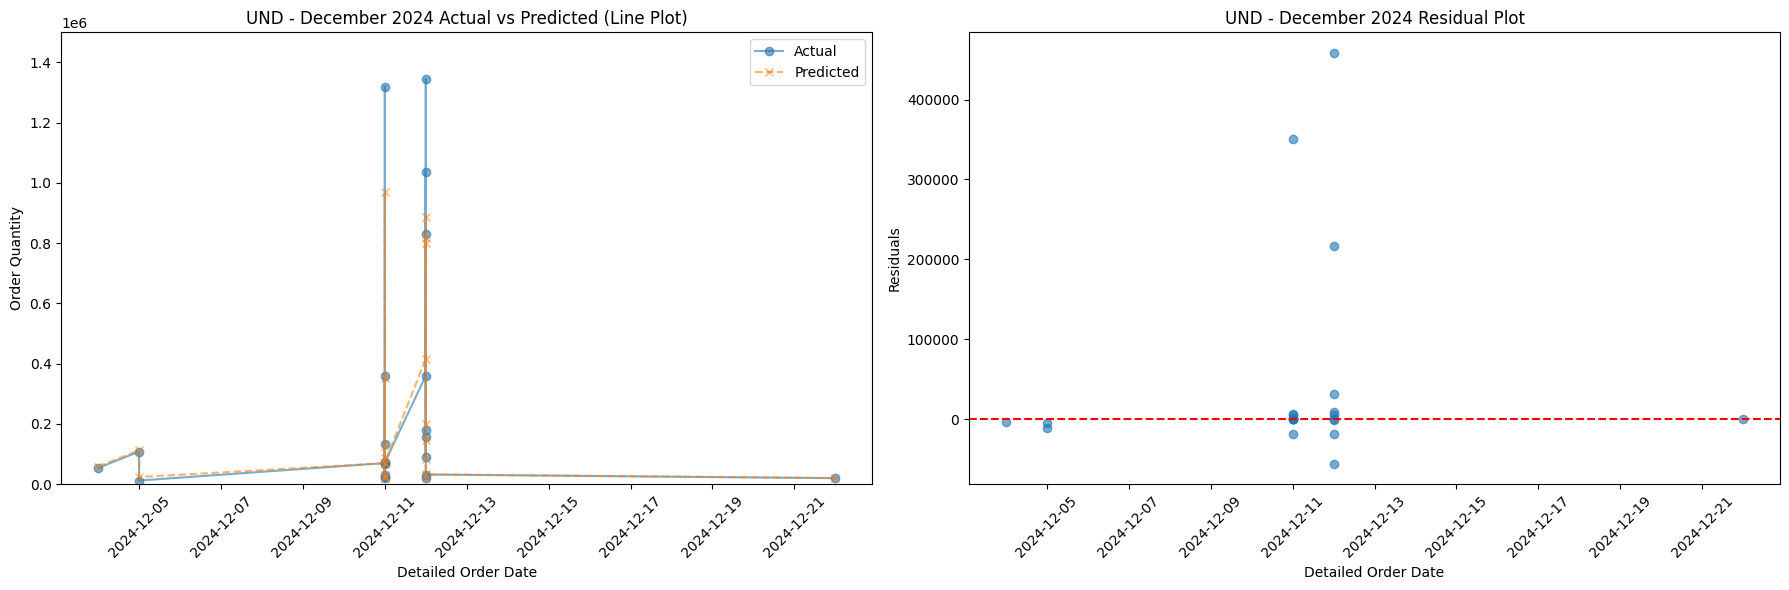

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Create a DetailedOrderDate column using week and weekday information.
# Adjust the format as needed based on your data.
customer_total['DetailedOrderDate'] = pd.to_datetime(
    customer_total['order_year'].astype(str) +
    customer_total['order_week'].astype(str).str.zfill(2) +
    customer_total['order_weekday'].astype(str),
    format='%Y%W%w'
)

# Filter the data for December 2024 using DetailedOrderDate
dec_2024_data = customer_total[
    (customer_total['DetailedOrderDate'].dt.year == 2024) &
    (customer_total['DetailedOrderDate'].dt.month == 12)
]

# Use only the common indices between dec_2024_data and y_val
common_index = dec_2024_data.index.intersection(y_val.index)
dec_2024_actual = y_val.loc[common_index]
# Convert y_pred_rf to a Series for indexing (using the same index as y_val)
y_pred_rf_series = pd.Series(y_pred_rf, index=y_val.index)
dec_2024_predicted = y_pred_rf_series.loc[common_index]

# --- Incorporate your provided sorting snippet, adapted for December 2024 data ---
# Here we sort by DetailedOrderDate from dec_2024_data for the common indices.
sorted_indices = dec_2024_data.loc[common_index, 'DetailedOrderDate'].argsort()
sorted_dates = dec_2024_data.loc[common_index, 'DetailedOrderDate'].iloc[sorted_indices]
sorted_actual = dec_2024_actual.iloc[sorted_indices]
sorted_predicted = dec_2024_predicted.iloc[sorted_indices]
# --- End of sorting snippet ---

# Create subplots (1 row, 2 columns: one for line plot, one for residual plot)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

# Line Plot: Actual vs. Predicted Order Quantity using DetailedOrderDate
axes[0].plot(sorted_dates, sorted_actual, label='Actual', alpha=0.6, marker='o', linestyle='-')
axes[0].plot(sorted_dates, sorted_predicted, label='Predicted', alpha=0.6, marker='x', linestyle='--')
axes[0].set_xlabel('Detailed Order Date')
axes[0].set_ylabel('Order Quantity')
axes[0].set_title(f'{custom_ref} - December 2024 Actual vs Predicted (Line Plot)')
axes[0].set_ylim(0, 1_500_000)
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)

# Residual Plot for December 2024
residuals_dec_2024 = sorted_actual - sorted_predicted
axes[1].scatter(sorted_dates, residuals_dec_2024, alpha=0.6)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel('Detailed Order Date')
axes[1].set_ylabel('Residuals')
axes[1].set_title(f'{custom_ref} - December 2024 Residual Plot')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [ ]:
import xgboost as xgb
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

X = df.drop("target_col", axis=1)
y = df["target_col"]

# Label encode categorical columns
label_encoders = {}
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# Impute missing values (X becomes a NumPy array)
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# XGBoost with GridSearchCV
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
param_grid = {'n_estimators': [100, 300], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 6]}
grid_xgb = GridSearchCV(xgb_model, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_xgb.fit(X_train, y_train)
best_xgb = grid_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

# Neural Network (MLPRegressor)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
mlp = MLPRegressor(hidden_layer_sizes=(128, 64), learning_rate_init=0.01,
                   max_iter=1000, early_stopping=True, random_state=42)
mlp.fit(X_train_scaled, y_train)
y_pred_mlp = mlp.predict(X_test_scaled)

# Compute performance metrics
models = {"Random Forest": y_pred_rf, "XGBoost": y_pred_xgb, "Neural Network": y_pred_mlp}
metrics = {}
for model_name, y_pred in models.items():
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    metrics[model_name] = [mae, mse, rmse, r2]

metrics_df = pd.DataFrame(metrics, index=['MAE', 'MSE', 'RMSE', 'R²'])
print(metrics_df)


AttributeError: 'numpy.ndarray' object has no attribute 'select_dtypes'

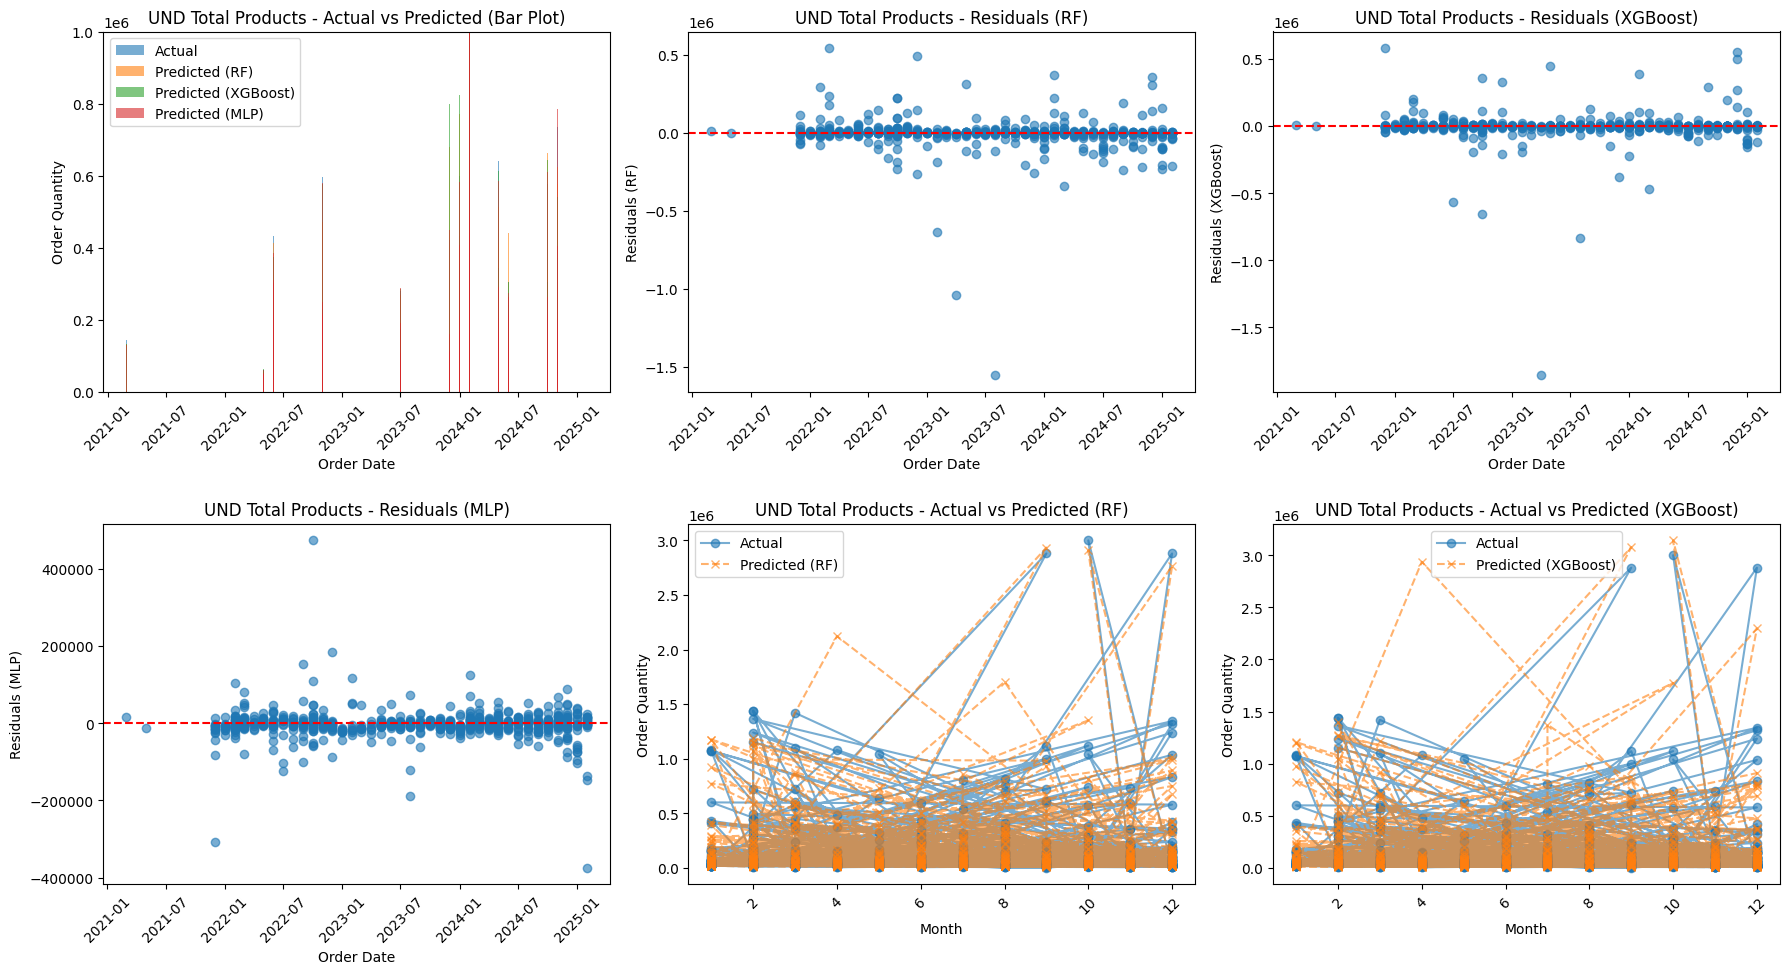

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Subplots to compare performance across models
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.3)  # Adjust layout for better spacing

# Ensure that you have y_pred_rf, y_pred_xgb, y_pred_mlp from model predictions
# Bar plot: Actual vs. Predicted Order Quantity for different models
axes[0, 0].bar(customer_total.loc[y_test.index, 'OrderDate'], y_test, label='Actual', alpha=0.6)
axes[0, 0].bar(customer_total.loc[y_test.index, 'OrderDate'], y_pred_rf, label='Predicted (RF)', alpha=0.6)
axes[0, 0].bar(customer_total.loc[y_test.index, 'OrderDate'], y_pred_xgb, label='Predicted (XGBoost)', alpha=0.6)
axes[0, 0].bar(customer_total.loc[y_test.index, 'OrderDate'], y_pred_mlp, label='Predicted (MLP)', alpha=0.6)
axes[0, 0].set_xlabel('Order Date')
axes[0, 0].set_ylabel('Order Quantity')
axes[0, 0].set_title(f'{custom_ref} Total Products - Actual vs Predicted (Bar Plot)')
axes[0, 0].set_ylim(0, 1_000_000)
axes[0, 0].legend()
axes[0, 0].tick_params(axis='x', rotation=45)

# Residual Plot for Random Forest
residuals_rf = y_test - y_pred_rf
axes[0, 1].scatter(customer_total.loc[y_test.index, 'OrderDate'], residuals_rf, alpha=0.6)
axes[0, 1].axhline(y=0, color='r', linestyle='--')
axes[0, 1].set_xlabel('Order Date')
axes[0, 1].set_ylabel('Residuals (RF)')
axes[0, 1].set_title(f'{custom_ref} Total Products - Residuals (RF)')
axes[0, 1].tick_params(axis='x', rotation=45)

# Residual Plot for XGBoost
residuals_xgb = y_test - y_pred_xgb
axes[0, 2].scatter(customer_total.loc[y_test.index, 'OrderDate'], residuals_xgb, alpha=0.6)
axes[0, 2].axhline(y=0, color='r', linestyle='--')
axes[0, 2].set_xlabel('Order Date')
axes[0, 2].set_ylabel('Residuals (XGBoost)')
axes[0, 2].set_title(f'{custom_ref} Total Products - Residuals (XGBoost)')
axes[0, 2].tick_params(axis='x', rotation=45)

# Residual Plot for Neural Network (MLP)
residuals_mlp = y_test - y_pred_mlp
axes[1, 0].scatter(customer_total.loc[y_test.index, 'OrderDate'], residuals_mlp, alpha=0.6)
axes[1, 0].axhline(y=0, color='r', linestyle='--')
axes[1, 0].set_xlabel('Order Date')
axes[1, 0].set_ylabel('Residuals (MLP)')
axes[1, 0].set_title(f'{custom_ref} Total Products - Residuals (MLP)')
axes[1, 0].tick_params(axis='x', rotation=45)

# Line Plot: Actual vs Predicted (Random Forest) for Yearly Trends
axes[1, 1].plot(customer_total.loc[y_test.index, 'order_month'], y_test, label='Actual', alpha=0.6, marker='o', linestyle='-')
axes[1, 1].plot(customer_total.loc[y_test.index, 'order_month'], y_pred_rf, label='Predicted (RF)', alpha=0.6, marker='x', linestyle='--')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Order Quantity')
axes[1, 1].set_title(f'{custom_ref} Total Products - Actual vs Predicted (RF)')
axes[1, 1].legend()
axes[1, 1].tick_params(axis='x', rotation=45)

# Line Plot: Actual vs Predicted (XGBoost) for Yearly Trends
axes[1, 2].plot(customer_total.loc[y_test.index, 'order_month'], y_test, label='Actual', alpha=0.6, marker='o', linestyle='-')
axes[1, 2].plot(customer_total.loc[y_test.index, 'order_month'], y_pred_xgb, label='Predicted (XGBoost)', alpha=0.6, marker='x', linestyle='--')
axes[1, 2].set_xlabel('Month')
axes[1, 2].set_ylabel('Order Quantity')
axes[1, 2].set_title(f'{custom_ref} Total Products - Actual vs Predicted (XGBoost)')
axes[1, 2].legend()
axes[1, 2].tick_params(axis='x', rotation=45)

# Adjust layout for better spacing between subplots
plt.tight_layout()
plt.show()
